# Impor Libraries

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2
from modules.gnn import GNN
from modules.graph import Graph
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from utils import *


/home/vale/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren??? 

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos
    * Predictor : MLPPredictor
    

## Entrenamiento

In [ ]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------



Done saving data into cached files.
None
Training edges: 261015
Validation edges: 86571
Test edges: 86393
In epoch 0, train loss: 1.575812816619873, val loss: 1.575854778289795
In epoch 10, train loss: 0.7368631362915039, val loss: 0.7378170490264893
In epoch 20, train loss: 0.5081464648246765, val loss: 0.509330689907074
In epoch 30, train loss: 0.40181979537010193, val loss: 0.40194663405418396
In epoch 40, train loss: 0.2704181373119354, val loss: 0.2684575021266937
In epoch 50, train loss: 0.2269231677055359, val loss: 0.22483325004577637
In epoch 60, train loss: 0.1952880620956421, val loss: 0.19401969015598297
In epoch 70, train loss: 0.1841132491827011, val loss: 0.1830548197031021
In epoch 80, train loss: 0.17754003405570984, val loss: 0.17656636238098145
In epoch 90, train loss: 0.17182794213294983, val loss: 0.1709505319595337


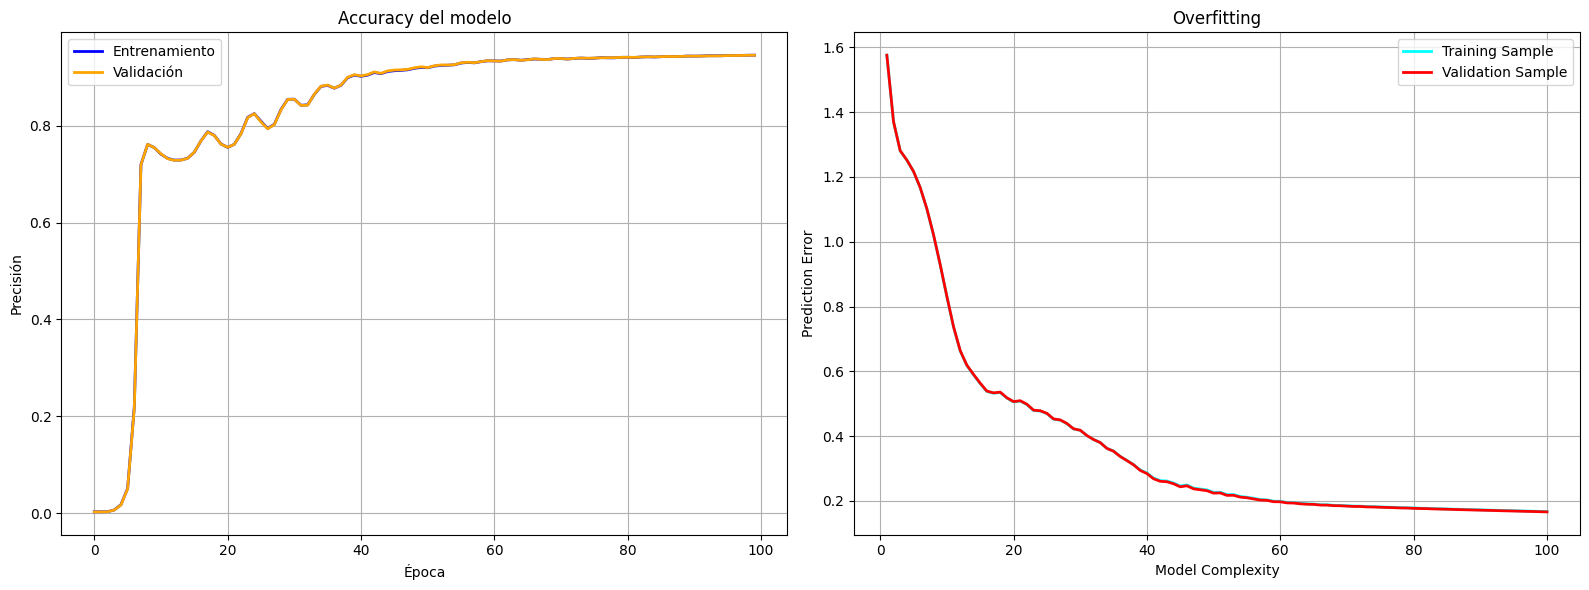

In [24]:

data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dtaset_v2()
# gnn.split_dataset(0.2)


edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mask = gnn.test_mask
val_mask = gnn.val_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

acc_val = []
acc_train = []



train_error = []
val_error = []
model_complexity = []

for e in range(100):
    # forward
    h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
    logits = pred(gnn.dgl_graph, h)
    scores = logits.argmax(1)
    labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)
    
    # Calcular la pérdida en el conjunto de entrenamiento
    train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    train_error.append(train_loss.item())
    
    # Calcular la pérdida en el conjunto de validación
    val_loss = F.cross_entropy(logits[gnn.val_mask], labels[gnn.val_mask])
    val_error.append(val_loss.item())
    
    # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
    model_complexity.append(e + 1)
    
    # Almacenar el valor de pérdida
    loss_values.append(train_loss.item())
    
    # Calcular la precisión en el conjunto de entrenamiento
    train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

    # Calcular la precisión en el conjunto de validación
    val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()

    # Guardar los valores de precisión
    acc_train.append(train_acc)
    acc_val.append(val_acc)

    # backward
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if e % 10 == 0:
        print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity)


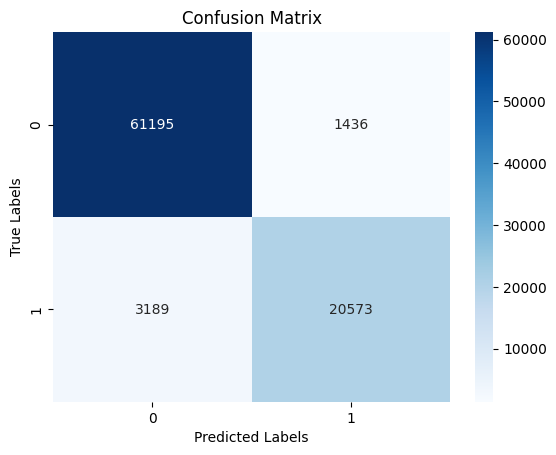

Classification Report:

              precision    recall  f1-score   support

           0     0.9505    0.9771    0.9636     62631
           2     0.9348    0.8658    0.8990     23762

    accuracy                         0.9465     86393
   macro avg     0.9426    0.9214    0.9313     86393
weighted avg     0.9461    0.9465    0.9458     86393



In [26]:
# ----------- 6. Calcular métricas -------------- #
predicted_train_scores = scores.detach().numpy()[test_mask]
true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
calculate_metrics(predicted_train_scores,true_train_labels)

In [27]:
# VERIFICAR CASO (AS1,AS2) -> (AS2,AS1) SE CLASIFICA IGUAL
u_all, v_all, ids_all = gnn.dgl_graph.edges(form='all')
ids_filtered = ids_all[train_mask]

dic_p2p = {}
dict_p2p_reverse = {}
for ids in ids_filtered:
    u, v = gnn.dgl_graph.find_edges(ids)
    true_label = edge_label[ids].item()
    pred_label = scores[ids].item()

    if true_label == 0:
        dic_p2p[(u.item(),v.item())] = pred_label
        # print(f"u: {u.item()}, v: {v.item()}")
        # print(f"True label: {edge_label[ids].item()}")
        # print(f"Predicted label: {scores[ids].item()}")


        edge_id_reverse =  gnn.dgl_graph.edge_ids(v, u)
        dict_p2p_reverse[(v.item(),u.item())] = scores[edge_id_reverse].item()
        # print(f"True label reverse: {edge_label[ids].item()}")
        # print(f"Predicted label reverse: {scores[ids].item()}")
    
    # print("---------------------------------------")

# Cantidad de correctos p2p
true = sum(1 for value in dic_p2p.values() if value == 0)
true_reverse = sum(1 for value in dict_p2p_reverse.values() if value == 0)
total_p2p = (predicted_scores == 0).sum().item()

# Calcular Accuracy
print(f"Cantidad True: {len(dic_p2p)} - Cantidad predicted: {true}")
print(f"cantidad True: {len(dict_p2p_reverse)} - Cantidad predicted: {true_reverse}")
print("[ACCURACY]",true/len(dic_p2p))
print("[ACCURACY REVERSE]",true_reverse/len(dict_p2p_reverse))
# Vemos que hay 5 que no s eradujieron igual q la ida

DGLError: Error: (4919, 0) does not form a valid edge.

In [126]:
print(f"Cantidad True: {len(dic_p2p)} - Cantidad predicted: {true}")
print(f"cantidad True: {len(dict_p2p_reverse)} - Cantidad predicted: {true_reverse}")
print("[ACCURACY]",true/len(dic_p2p))
print("[ACCURACY REVERSE]",true_reverse/len(dict_p2p_reverse))

Cantidad True: 125343 - Cantidad predicted: 122355
cantidad True: 125343 - Cantidad predicted: 122350
[ACCURACY] 0.9761614130825016
[ACCURACY REVERSE] 0.9761215225421443


# Caso 2: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : MLPPredictor
    

## Entrenamiento

In [28]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
"""
node_id,feat
1,"17, 17"
7843,"87, 87"
11537,"119, 119"
"""

path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEMultiDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA GRAFO]",graph.nx_graph)

# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)



[TOPOLOGÍA GRAFO] MultiDiGraph with 74145 nodes and 923778 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEMultiDiGraphDegree/nodes.csv]
MultiDiGraph with 74145 nodes and 923778 edges
MultiDiGraph with 74145 nodes and 923778 edges
MultiDiGraph with 74145 nodes and 923778 edges


In [7]:

data_path = "datasets/DGL_Graph/MYCODEMultiDiGraphDegree/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() # FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Almacenar los valores de Loss y Accuracy
acc_val = []
acc_train = []

train_error = []
val_error = []

model_complexity = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.cross_entropy(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())
  
  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

  # Calcular la precisión en el conjunto de validación
  val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()


  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()


  # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
  model_complexity.append(e + 1)

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

# #     # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# # # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')




# ----------- 5. plot the loss and accuracy -------------- #

plot_training(train_error,acc_train,val_error,acc_val,model_complexity)

KeyError: 0

In [4]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)

NameError: name 'test_mak' is not defined

In [131]:
# VERIFICAR CASO (AS1,AS2) -> (AS2,AS1) SE CLASIFICA IGUAL
u_all, v_all, ids_all = gnn.dgl_graph.edges(form='all')
ids_filtered = ids_all[train_mask]

dic_p2p = {}
dict_p2p_reverse = {}
for ids in ids_filtered:
    u, v = gnn.dgl_graph.find_edges(ids)
    true_label = edge_label[ids].item()
    pred_label = scores[ids].item()

    if true_label == 0:
        dic_p2p[(u.item(),v.item())] = pred_label
        # print(f"u: {u.item()}, v: {v.item()}")
        # print(f"True label: {edge_label[ids].item()}")
        # print(f"Predicted label: {scores[ids].item()}")


        edge_id_reverse =  gnn.dgl_graph.edge_ids(v, u)
        dict_p2p_reverse[(v.item(),u.item())] = scores[edge_id_reverse].item()
        # print(f"True label reverse: {edge_label[ids].item()}")
        # print(f"Predicted label reverse: {scores[ids].item()}")
    
    # print("---------------------------------------")

# Cantidad de correctos p2p
true = sum(1 for value in dic_p2p.values() if value == 0)
true_reverse = sum(1 for value in dict_p2p_reverse.values() if value == 0)
total_p2p = (predicted_scores == 0).sum().item()

# Calcular Accuracy
print(f"Cantidad True: {len(dic_p2p)} - Cantidad predicted: {true}")
print(f"cantidad True: {len(dict_p2p_reverse)} - Cantidad predicted: {true_reverse}")
print("[ACCURACY]",true/len(dic_p2p))
print("[ACCURACY REVERSE]",true_reverse/len(dict_p2p_reverse))
# Vemos que hay 5 que no s eradujieron igual q la ida

Cantidad True: 377377 - Cantidad predicted: 359885
cantidad True: 377377 - Cantidad predicted: 359862
[ACCURACY] 0.9536484735423727
[ACCURACY REVERSE] 0.9535875265318237


# Caso 3: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [3]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEMultiDiGraph/"  


graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)

# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
LIST_FEATURES_CATEG = ['AS_rank_continent',
                        'peeringDB_info_ratio',
                        'peeringDB_info_scope',
                        'peeringDB_info_type',
                        'peeringDB_policy_general'
                        'ASDB_C1L1']

# Crear Di graph 
list_feat = ['AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']  +  LIST_FEATURES_CATEG
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

Graph with 46720 nodes and 434464 edges
Graph with 46243 nodes and 433987 edges
Graph with 46235 nodes and 433979 edges


Done saving data into cached files.
None
Training edges: 554622
Validation edges: 184952
Test edges: 184204
In epoch 0, loss: 1.2463526725769043
In epoch 10, loss: 0.8349955677986145
In epoch 20, loss: 0.7825454473495483
In epoch 30, loss: 0.704828679561615
In epoch 40, loss: 0.5993185639381409
In epoch 50, loss: 0.4253402054309845
In epoch 60, loss: 0.2972804009914398
In epoch 70, loss: 0.2852996289730072
In epoch 80, loss: 0.26856040954589844
In epoch 90, loss: 0.25902059674263


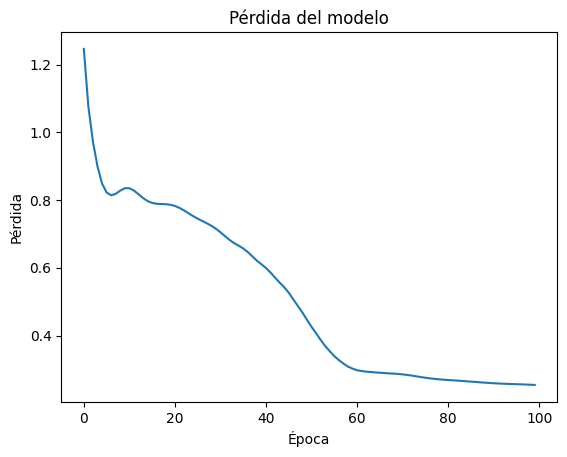

In [132]:
data_path = "datasets/DGL_Graph/MYCODEMultiDiGraphDegree/"

gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() # FIXME:

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
# model = GCN(in_feats, h_feats, num_clases)
# pred = DotPredictor()

model = GraphSAGE(gnn.dgl_graph.ndata['feat'].shape[1], 16,8)
pred = MLPPredictor(8,3)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Almacenar los valores de Loss y Accuracy
acc_val = []
acc_train = []

train_error = []
val_error = []

model_complexity = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  # scores = torch.argmax(logits, dim=1)
  scores = logits.argmax(1)
  labels = gnn.dgl_graph.edata["Relationship"].to(torch.int64)

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.cross_entropy(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.cross_entropy(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = (scores[train_mask] == labels[train_mask]).float().mean().item()

  # Calcular la precisión en el conjunto de validación
  val_acc = (scores[gnn.val_mask] == labels[gnn.val_mask]).float().mean().item()



  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()


  # Guardar la complejidad del modelo (en este caso, usamos el número de épocas)
  model_complexity.append(e + 1)

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

# #     # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# # # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')


CALCULO
ELSE
Classification Report:

              precision    recall  f1-score   support

           0     0.9327    0.9670    0.9495    125189
           1     0.9051    0.8255    0.8635     29612
           2     0.8939    0.8331    0.8624     29403

    accuracy                         0.9229    184204
   macro avg     0.9106    0.8752    0.8918    184204
weighted avg     0.9220    0.9229    0.9218    184204



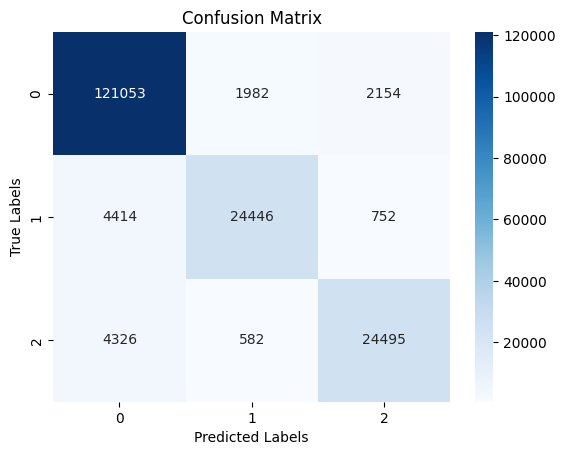

In [133]:
from utils import cal_acc_pres_f1
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
cal_acc_pres_f1(predicted_scores,true_labels, threshold=None)

In [134]:
# VERIFICAR CASO (AS1,AS2) -> (AS2,AS1) SE CLASIFICA IGUAL
u_all, v_all, ids_all = gnn.dgl_graph.edges(form='all')
ids_filtered = ids_all[train_mask]

dic_p2p = {}
dict_p2p_reverse = {}
for ids in ids_filtered:
    u, v = gnn.dgl_graph.find_edges(ids)
    true_label = edge_label[ids].item()
    pred_label = scores[ids].item()

    if true_label == 0:
        dic_p2p[(u.item(),v.item())] = pred_label
        # print(f"u: {u.item()}, v: {v.item()}")
        # print(f"True label: {edge_label[ids].item()}")
        # print(f"Predicted label: {scores[ids].item()}")


        edge_id_reverse =  gnn.dgl_graph.edge_ids(v, u)
        dict_p2p_reverse[(v.item(),u.item())] = scores[edge_id_reverse].item()
        # print(f"True label reverse: {edge_label[ids].item()}")
        # print(f"Predicted label reverse: {scores[ids].item()}")
    
    # print("---------------------------------------")

# Cantidad de correctos p2p
true = sum(1 for value in dic_p2p.values() if value == 0)
true_reverse = sum(1 for value in dict_p2p_reverse.values() if value == 0)
total_p2p = (predicted_scores == 0).sum().item()

# Calcular Accuracy
print(f"Cantidad True: {len(dic_p2p)} - Cantidad predicted: {true}")
print(f"cantidad True: {len(dict_p2p_reverse)} - Cantidad predicted: {true_reverse}")
print("[ACCURACY]",true/len(dic_p2p))
print("[ACCURACY REVERSE]",true_reverse/len(dict_p2p_reverse))
# Vemos que hay 5 que no s eradujieron igual q la ida

Cantidad True: 377326 - Cantidad predicted: 364794
cantidad True: 377326 - Cantidad predicted: 364847
[ACCURACY] 0.9667873403900076
[ACCURACY REVERSE] 0.9669278024837938


# BGP2VEC

## Crear Emberddings

In [11]:
# Embeddings ASN BGP2VEC
import os
from bgp2vec.bgp2vec import BGP2VEC
from gensim.models import Word2Vec

oix_path = os.getcwd()+  "/datasets/RouteViews/Download/oix-full-snapshot-2022-06-30-2000.bz2"
test_limit = 2000000 #cantidad paths/horaciones
mode = None# 'test' # par limitar cantidad de paths/oraciones
epochs = 1
debug = True
model_path = os.getcwd()+"/bgp2vec/bgp2vec.word2vec"

# Crea embeddings de ASN con  BGP2VEC y lo guarda en "/bgp2vec/bgp2vec.word2vec"
bgp2vec = BGP2VEC(model_path = model_path ,oix_path=oix_path,rewrite=True, test_limit= test_limit, mode = mode, epochs = epochs)

print("[MODELO]",bgp2vec.model)
print("[TOTAL ASN]",bgp2vec.model.corpus_total_words)

# index = bgp2vec.model.wv['701']
# print(f"[INDEX ASN {'701'}] {index}")
# print(f"[INDEX ASN {'701'}] {bgp2vec.asn2vec('701')}")
# print("IMPOT ")
# MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"
# print(f"PATH {MODELS_PATH}")
# BGP2Vec_model = Word2Vec.load(MODELS_PATH)

Warning! PYTHONHASHSEED is not defined
[MODELO] Word2Vec<vocab=74238, vector_size=32, alpha=0.025>
[TOTAL ASN] 120491185


## Importar Embeddings

In [12]:
MODELS_PATH = os.getcwd() + "/bgp2vec/bgp2vec.word2vec"

# Importar embeddings ASN
BGP2Vec_model = Word2Vec.load(MODELS_PATH)

emdeddings = BGP2Vec_model.wv.vectors
total_ASNs, embedding_vecor_length = emdeddings.shape

print(f"[TOTAL ASN]: {total_ASNs}" )

print(f"[EMBEDDINGS LEN]: {embedding_vecor_length}")
print(f"[EMBEDDINGS] {emdeddings}")

[TOTAL ASN]: 74238
[EMBEDDINGS LEN]: 32
[EMBEDDINGS] [[-2.1472703e-01  6.3407493e-01  2.6631510e-01 ... -6.7314707e-02
   5.2685094e-01  9.1462356e-01]
 [-1.3031145e+00  8.3815610e-01  5.3771269e-01 ... -2.9695952e-01
  -2.3368393e-01  4.5706276e-02]
 [-7.9452795e-01  5.5671680e-01 -6.1896056e-01 ... -2.6427367e-01
  -2.6843885e-01  1.3504244e+00]
 ...
 [-1.1700593e-02 -1.3378471e-02  5.4460280e-03 ...  2.8491393e-04
  -1.2418743e-02  2.4866499e-03]
 [ 2.3998376e-02  1.9970149e-02 -2.5604732e-02 ...  1.7985072e-02
   5.2202269e-03 -3.0413084e-02]
 [ 7.9072835e-03 -3.8274422e-02 -4.1166581e-02 ...  3.5102013e-02
   9.1040730e-03 -3.5600732e-03]]


## Dataset AS Relationships

In [1]:
from utils import edges_and_relationships_from_dgl_graph


In [14]:
# Datset TOR
data_path = "datasets/DGL_Graph/MYCODEMultiDiGraph/"
gnn = GNN(debug = True)
gnn.load_dataset(data_path,force_reload= True) # No hay nodos con grado 0

list_edges, labels = edges_and_relationships_from_dgl_graph(gnn.dgl_graph)

print("[EDGES]\n",list_edges)
print("[LABELS]", labels)

Done saving data into cached files.
None
[EDGES]
 [[    0  2858]
 [    0  4919]
 [    0 21556]
 ...
 [ 6630 74143]
 [73477 74143]
 [73870 74143]]
[LABELS] [0 0 0 ... 2 2 2]


## Split Dataset

In [15]:
TEST_SIZE = 0.2
# Generat indices para dataset
indices = np.arange(len(list_edges))

x_training, x_test, indices_training, indices_test = train_test_split(list_edges, indices, test_size=TEST_SIZE) 
y_training = labels[indices_training]
y_test = labels[indices_test]

In [16]:
print("[TRAINING]" ,x_training.shape, y_training.shape)
print("[TEST]",x_test.shape, y_test.shape)

print("[TRAINIG %]",1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print("[COUNTER TRAINING]",training_c)
print("[COUNTER TEST]",test_c)

[TRAINING] (739022, 2) (739022,)
[TEST] (184756, 2) (184756,)
[TRAINIG %] 0.7999995669955335
[COUNTER TRAINING] Counter({0: 502320, 1: 118423, 2: 118279})
[COUNTER TEST] Counter({0: 126058, 2: 29421, 1: 29277})


## Modelo NN

In [17]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)
# !pip uninstall torch -y   # py -m pip uninstall tensorflow -y

# pip install torch==2.4 # py -m pip install tensorflow==2.4
# pip install tensorflow==1.13.1

2.17.0
3.5.0


In [18]:
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
# from keras.layers import LSTM
# from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding
# from keras.preprocessing import sequence
# from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import to_categorical
from keras.callbacks import TensorBoard,ModelCheckpoint

### Red Neuronal Superficial
Sacada del codigo de BGP2VEC

In [19]:
# Configuración de la RNN BGP2VEC
experiment = None

embedding_trainable = False
input_length = 2
num_classes = 3
embedding_vector_length = 32  # Corrige el error tipográfico
total_ASNs = 74238
MODEL_NAME = "Model_bgp_"

# Registro de parámetros del experimento si es aplicable
if experiment is not None:
    experiment.log_parameter("embedding_trainable", embedding_trainable)

# Definición del modelo
model = Sequential()
model.add(Embedding(total_ASNs, embedding_vector_length, input_length=input_length,
                    weights=[emdeddings], trainable=True))  # Asegúrate de que 'emdeddings' esté definida
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))

model.add(Reshape((32, 2)))  # Cambia Reshape para reflejar las dimensiones correctas
#model.add(Reshape((model.output_shape[2], model.output_shape[1])))  # Cambia Reshape para reflejar las dimensiones correctas
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((32,16)))  # Cambia Reshape para reflejar las dimensiones correctas
#model.add(Reshape((model.output_shape[2], model.output_shape[1])))  # Cambia Reshape para reflejar las dimensiones correctas
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compilación del modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
print(model.summary())


c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,375,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,375,616 (9.06 MB)

 Trainable params: 2,375,616 (9.06 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Convert class vectors to binary class matrices
y_training_vector = to_categorical(y_training, num_classes)
y_test_vector = to_categorical(y_test, num_classes)



In [21]:
# Use class_weight to deal with unbalanced dataset
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', list(range(num_classes)), y_training)
# print(class_weights)
class_weights = None

In [22]:
# Fit model
checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_acc.weights.h5',
                                    verbose=1, 
                                    save_best_only=True, 
                                    save_weights_only=True)

checkpointer_loss = ModelCheckpoint(filepath= os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_loss.weights.h5', 
                                    verbose=1, 
                                    save_best_only=True, 
                                    save_weights_only=True)

callbacks = [checkpointer_loss,checkpointer_acc] #tensorboard

In [23]:
import math
experiment = None
epochs = 40 #################################   3  ##########
if experiment is not None:
    experiment.log_parameter("epochs", epochs)

batch_size = 64
if experiment is not None:
    experiment.log_parameter("batch_size", batch_size)

steps_per_epoch = math.ceil(len(x_training)/batch_size)
if experiment is not None:
    experiment.log_parameter("steps_per_epoch", steps_per_epoch)

val_batch_size = 1024
if experiment is not None:
    experiment.log_parameter("val_batch_size", val_batch_size)

validation_steps = math.ceil(len(x_test)/val_batch_size)
if experiment is not None:
    experiment.log_parameter("validation_steps", validation_steps)

def val_generator(features, labels, val_batch_size):
    index = 0
    while True:
        index += val_batch_size
        batch_features, batch_labels = features[index-val_batch_size:index], labels[index-val_batch_size:index]
        if index >= len(features):
            index = 0
        yield batch_features, batch_labels
        
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]


In [24]:
# if experiment is not None:
#     with experiment.train():
#         history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
#                         epochs=epochs, callbacks=callbacks, class_weight=class_weights,
#                         validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
#                         validation_steps=validation_steps)
# else:
#     history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
#                         epochs=epochs, callbacks=callbacks, class_weight=class_weights,
#                         validation_data=val_generator(x_test, y_test_vector,val_batch_size), 
#                         validation_steps=validation_steps)

if experiment is not None:
    with experiment.train():
        history = model.fit(
            x=val_generator(x_training, y_training_vector, batch_size),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=class_weights,
            validation_data=val_generator(x_test, y_test_vector, val_batch_size),
            validation_steps=validation_steps
        )
else:
    history = model.fit(
        x=val_generator(x_training, y_training_vector, batch_size),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        validation_data=val_generator(x_test, y_test_vector, val_batch_size),
        validation_steps=validation_steps
    )


Epoch 1/40
11547/11548 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8937 - loss: 0.2913
Epoch 1: val_loss improved from inf to 0.11960, saving model to c:\Users\Vale\Desktop\GIT\TESIS/bgp2vec/Model_bgp__loss.weights.h5
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 196s 17ms/step - accuracy: 0.8937 - loss: 0.2912 - val_accuracy: 0.9614 - val_loss: 0.1196
Epoch 2/40
   13/11548 ━━━━━━━━━━━━━━━━━━━━ 2:48 15ms/step - accuracy: 0.9574 - loss: 0.1259

c:\Users\Vale\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


11547/11548 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9667 - loss: 0.1021
Epoch 2: val_loss improved from 0.11960 to 0.10018, saving model to c:\Users\Vale\Desktop\GIT\TESIS/bgp2vec/Model_bgp__loss.weights.h5
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 193s 17ms/step - accuracy: 0.9667 - loss: 0.1021 - val_accuracy: 0.9681 - val_loss: 0.1002
Epoch 3/40
11547/11548 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9743 - loss: 0.0784
Epoch 3: val_loss improved from 0.10018 to 0.09341, saving model to c:\Users\Vale\Desktop\GIT\TESIS/bgp2vec/Model_bgp__loss.weights.h5
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 189s 16ms/step - accuracy: 0.9743 - loss: 0.0784 - val_accuracy: 0.9704 - val_loss: 0.0934
Epoch 4/40
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9788 - loss: 0.0641
Epoch 4: val_loss improved from 0.09341 to 0.09244, saving model to c:\Users\Vale\Desktop\GIT\TESIS/bgp2vec/Model_bgp__loss.weights.h5
11548/11548 ━━━━━━━━━━━━━━━━━━━━ 207s 18ms/step - accuracy: 0.9788 - loss: 0.0641 - v

KeyboardInterrupt: 

## Plot history accuracy

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


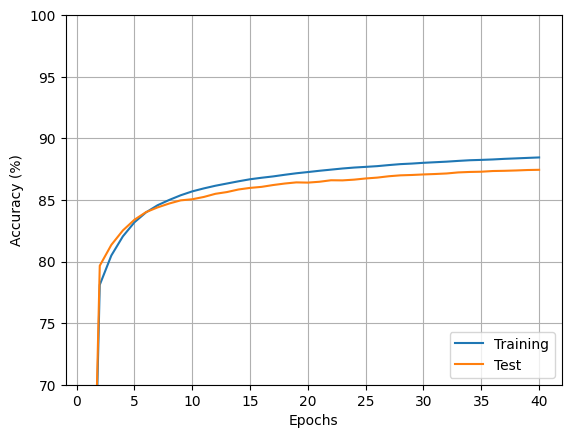

In [ ]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


with open(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)
    if experiment is not None:
        experiment.log_asset(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  "_accuracy.pkl")
    
# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, smooth([y*100 for y in history.history['accuracy']],2))
# plt.plot(x, [y*100 for y in history_history['val_acc']])
plt.plot(x, smooth([y*100 for y in history.history['val_accuracy']],2))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim(70,100) ###########################
plt.legend(['Training', 'Test'], loc='lower right')
plt.grid()
plt.savefig(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME +  " accuracy history", bbox_inches='tight')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/results_" + MODEL_NAME + " accuracy history.png")
plt.show()

## Final evaluation of the model

In [ ]:
# Evaluate accuracy over the test set
# model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')
# model.load_weights(os.getcwd() + "/bgp2vec/" + MODEL_NAME + '_acc.weights.h5')

In [ ]:
test_scores = model.evaluate(x_test, y_test_vector, batch_size=val_batch_size, verbose=1)
    
    
print("Accuracy: %.2f%%" % (test_scores[1]*100))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8762 - loss: 0.3372
Accuracy: 87.59%


In [ ]:
# y_test_prediction = model.predict_classes(x_test, batch_size=val_batch_size, verbose=1)
y_test_predictions_prob = model.predict(x_test, batch_size=val_batch_size, verbose=1)
# Obtener las clases predichas
y_test_prediction = np.argmax(y_test_predictions_prob, axis=1)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# y_training_prediction = model.predict_classes(x_training, batch_size=val_batch_size, verbose=1)
y_training_predictions_prob = model.predict(x_training, batch_size=val_batch_size, verbose=1)
# Obtener las clases predichas
y_training_prediction = np.argmax(y_training_predictions_prob, axis=1)

722/722 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [ ]:
#Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa


p2c = 2
c2p = 1

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])

p2c_training_label_vector = to_categorical([p2c]*len(p2c_training), num_classes)
p2c_training_oposite_label_vector = to_categorical([c2p]*len(p2c_training_oposite), num_classes)

print(p2c_training.shape, p2c_training_oposite.shape, p2c_training_oposite_label_vector.shape)


(118229, 2) (118229, 2) (118229, 3)


In [ ]:
p2c_training_scores = model.evaluate(p2c_training, p2c_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_scores[1]*100))

p2c_training_oposite_scores = model.evaluate(p2c_training_oposite, p2c_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores[1]*100))

3695/3695 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7575 - loss: 0.6083
Accuracy: 75.65%
3695/3695 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6911 - loss: 0.7303
Accuracy: 69.27%


In [46]:
#Test if by learning (asn1, asn2) -> p2p then (asn2, asn1) -> p2p and vice versa

p2p = 0

p2p_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2p])
p2p_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2p_training])

p2p_training_label_vector = to_categorical([p2p]*len(p2p_training), num_classes)
p2p_training_oposite_label_vector = to_categorical([p2p]*len(p2p_training_oposite), num_classes)

p2p_training_label_vector


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [ ]:
p2p_training_scores = model.evaluate(p2p_training, p2p_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_scores[1]*100))

p2p_training_oposite_scores = model.evaluate(p2p_training_oposite, p2p_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_oposite_scores[1]*100))


15709/15709 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9642 - loss: 0.1259
Accuracy: 96.39%
15709/15709 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.9630 - loss: 0.1294
Accuracy: 96.29%


## Plot and save a confusion matrix for results over the test set

In [ ]:
# Define a function
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow([[100*j for j in i] for i in cm], interpolation='nearest', cmap=cmap)
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

In [ ]:
class_names = ['P2P', 'C2P', 'P2C']

Confusion matrix, without normalization
Normalized confusion matrix


C:\Users\Vale\AppData\Local\Temp\ipykernel_14884\276448347.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


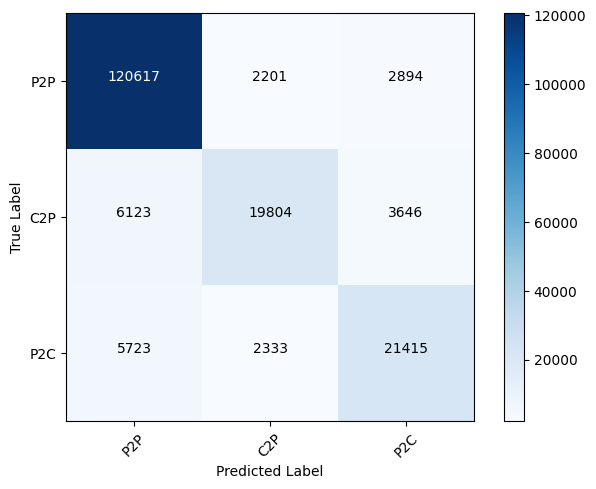

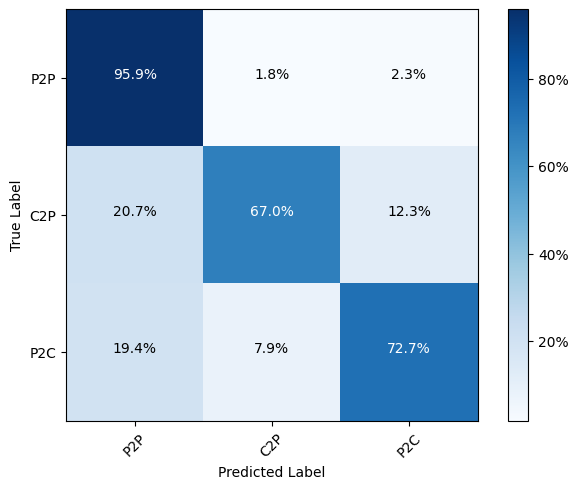

In [ ]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=os.getcwd()+ "/bgp2vec/results_"  + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(os.getcwd()+ "/bgp2vec/results_"  + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization.png', 
                         name='Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=os.getcwd()+ "/bgp2vec/results_"  +MODEL_NAME + "_" + 'Normalized_confusion_matrix')

if experiment is not None:
    experiment.log_image(os.getcwd()+ "/bgp2vec/results_" + MODEL_NAME + "_" + 'Normalized_confusion_matrix.png',
                         name='Normalized_confusion_matrix.png')

plt.show()


Confusion matrix, without normalization
Normalized confusion matrix


C:\Users\Vale\AppData\Local\Temp\ipykernel_14884\276448347.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])


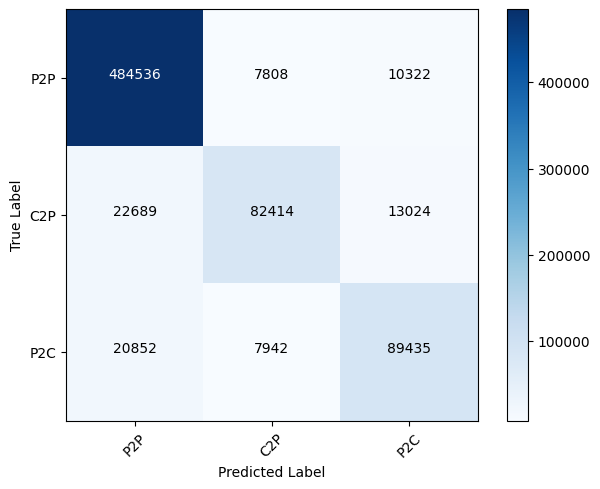

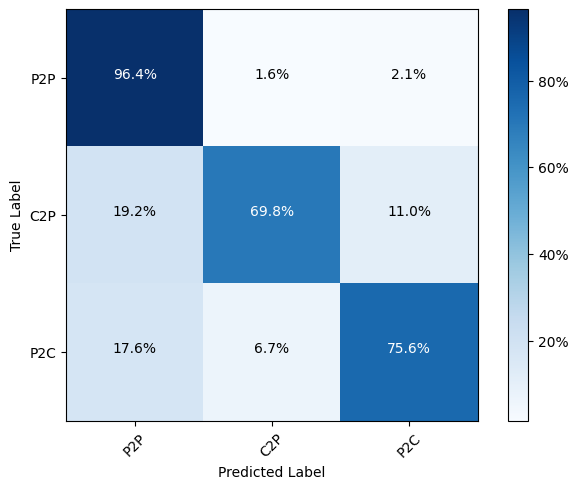

In [ ]:
# Plot cm for training set

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_training, y_training_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname= os.getcwd() + "/bgp2vec/result_" + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/result_"  + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix',
                      fname=os.getcwd() + "/bgp2vec/result_"  +MODEL_NAME + "_" + 'training_Normalized_confusion_matrix')
if experiment is not None:
    experiment.log_image(os.getcwd() + "/bgp2vec/result_"  + MODEL_NAME + "_" + 'training_Normalized_confusion_matrix.png')

plt.show()

### Red Neuronal Superficial pytorch
Sacada del codigo de BGP2VEC, pero con pytorch en ves de keras

In [ ]:
# Importar Embeddings

In [ ]:
import torch
import torch.nn as nn

# Supongamos que los embeddings están en un array de numpy llamado `bgp2vec_embeddings`
embedding_dim = 32  # Dimensión del embedding
input_length = 5    # Longitud de la secuencia de entrada
vocab_size = bgp2vec_embeddings.shape[0]  # Total de ASNs

# Crear la capa de embedding usando los embeddings preentrenados
embedding_layer = nn.Embedding.from_pretrained(torch.tensor(bgp2vec_embeddings, dtype=torch.float32), freeze=True)

# Definir un modelo sencillo
class BGP2VECModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, input_length):
        super(BGP2VECModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(bgp2vec_embeddings, dtype=torch.float32), freeze=True)
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * (input_length // 2), 100)  # Nota: //2 porque el pooling reduce la dimensión
        self.fc2 = nn.Linear(100, 3)  # Número de clases

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Cambiar las dimensiones a (batch_size, embedding_dim, input_length)
        x = self.conv1d(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = BGP2VECModel(vocab_size, embedding_dim, input_length)


In [ ]:
# TODO: Se siguen entrenando los embeddings en la RNN
# TODO: porque no se esta guardando acc del modelo por batch
# TODO: Diferencia entre test y val